In [6]:
import numpy as np
import sys
sys.path.append('..')

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(c, W)
print(h)

from common.layers import MatMul

layer = MatMul(W)
h = layer.forward(c)
print(h)


c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[0.90503202 0.14628295 1.57988759]]
[[0.90503202 0.14628295 1.57988759]]
[[-0.37418247  1.30913372  0.95793524  0.03387667  0.01617323 -1.04594345
   0.01460285]]


In [14]:
from common.util import preprocess
text ='You say goodbye and I say Hello.'
corpus, word_to_id, id_to_word = preprocess(text)

def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成

    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus)
print(contexts)
print(target)


def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


vocab_size =len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(contexts)
print(target)


[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [15]:
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 314 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 315 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 316 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 317 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 318 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 319 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 320 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 321 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 322 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 323 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 324 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 325 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 326 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 327 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 328 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 329 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 330 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 331 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 332 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 333 |  iter 1 / 2 | time 0[s] | loss 1.05


| epoch 612 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 613 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 614 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 615 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 616 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 617 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 618 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 619 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 620 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 621 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 622 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 623 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 624 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 625 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 626 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 627 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 628 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 629 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 630 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 631 |  iter 1 / 2 | time 0[s] | loss 0.60


| epoch 934 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 935 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 936 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 937 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 938 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 939 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 940 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 941 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 942 |  iter 1 / 2 | time 0[s] | loss 0.41
| epoch 943 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 944 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 945 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 946 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 947 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 948 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 949 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 950 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 951 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 952 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 953 |  iter 1 / 2 | time 0[s] | loss 0.66


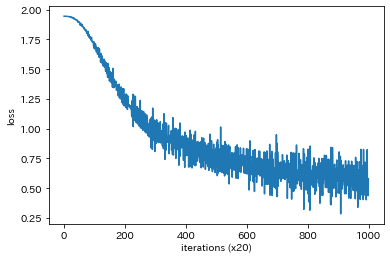

you [-1.1682831  0.9944652 -1.0971166  1.1370467  1.3011928]
say [ 1.1602688  -1.1815921   1.186294   -1.163063   -0.01054916]
goodbye [-0.7363993   0.90770185 -0.7776591   0.6959041   0.64631486]
and [ 0.8900947  -0.8991628   0.88745475 -0.8572797   2.0952125 ]
i [-0.7292442   0.90868866 -0.779685    0.71659565  0.66402274]
hello [-1.1713318   0.99628747 -1.0801396   1.1286966   1.2881426 ]
. [ 1.1036736 -1.150985   1.149131  -1.1615486 -1.6948049]


In [17]:
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 |  iter 1 / 2 | ti

| epoch 272 |  iter 1 / 2 | time 0[s] | loss 2.55
| epoch 273 |  iter 1 / 2 | time 0[s] | loss 2.49
| epoch 274 |  iter 1 / 2 | time 0[s] | loss 2.33
| epoch 275 |  iter 1 / 2 | time 0[s] | loss 2.38
| epoch 276 |  iter 1 / 2 | time 0[s] | loss 2.14
| epoch 277 |  iter 1 / 2 | time 0[s] | loss 2.48
| epoch 278 |  iter 1 / 2 | time 0[s] | loss 2.32
| epoch 279 |  iter 1 / 2 | time 0[s] | loss 2.47
| epoch 280 |  iter 1 / 2 | time 0[s] | loss 2.37
| epoch 281 |  iter 1 / 2 | time 0[s] | loss 2.35
| epoch 282 |  iter 1 / 2 | time 0[s] | loss 2.36
| epoch 283 |  iter 1 / 2 | time 0[s] | loss 2.41
| epoch 284 |  iter 1 / 2 | time 0[s] | loss 2.35
| epoch 285 |  iter 1 / 2 | time 0[s] | loss 2.29
| epoch 286 |  iter 1 / 2 | time 0[s] | loss 2.28
| epoch 287 |  iter 1 / 2 | time 0[s] | loss 2.40
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 2.23
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 2.51
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 2.27
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 2.15


| epoch 529 |  iter 1 / 2 | time 0[s] | loss 1.80
| epoch 530 |  iter 1 / 2 | time 0[s] | loss 2.20
| epoch 531 |  iter 1 / 2 | time 0[s] | loss 1.98
| epoch 532 |  iter 1 / 2 | time 0[s] | loss 1.78
| epoch 533 |  iter 1 / 2 | time 0[s] | loss 1.99
| epoch 534 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 535 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 536 |  iter 1 / 2 | time 0[s] | loss 1.79
| epoch 537 |  iter 1 / 2 | time 0[s] | loss 2.19
| epoch 538 |  iter 1 / 2 | time 0[s] | loss 1.77
| epoch 539 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 540 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 541 |  iter 1 / 2 | time 0[s] | loss 2.01
| epoch 542 |  iter 1 / 2 | time 0[s] | loss 1.75
| epoch 543 |  iter 1 / 2 | time 0[s] | loss 2.03
| epoch 544 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 545 |  iter 1 / 2 | time 0[s] | loss 1.79
| epoch 546 |  iter 1 / 2 | time 0[s] | loss 2.21
| epoch 547 |  iter 1 / 2 | time 0[s] | loss 1.77
| epoch 548 |  iter 1 / 2 | time 0[s] | loss 1.99


| epoch 808 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 809 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 810 |  iter 1 / 2 | time 0[s] | loss 1.70
| epoch 811 |  iter 1 / 2 | time 0[s] | loss 2.35
| epoch 812 |  iter 1 / 2 | time 0[s] | loss 1.69
| epoch 813 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 814 |  iter 1 / 2 | time 0[s] | loss 1.92
| epoch 815 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 816 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 817 |  iter 1 / 2 | time 0[s] | loss 1.68
| epoch 818 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 819 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 820 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 821 |  iter 1 / 2 | time 0[s] | loss 1.69
| epoch 822 |  iter 1 / 2 | time 0[s] | loss 1.68
| epoch 823 |  iter 1 / 2 | time 0[s] | loss 2.35
| epoch 824 |  iter 1 / 2 | time 0[s] | loss 1.67
| epoch 825 |  iter 1 / 2 | time 0[s] | loss 2.14
| epoch 826 |  iter 1 / 2 | time 0[s] | loss 1.68
| epoch 827 |  iter 1 / 2 | time 0[s] | loss 1.90


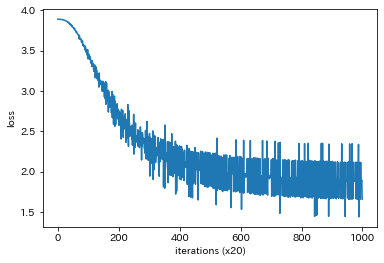

you [-0.00364752 -0.01221794  0.00529559  0.00430045  0.00467898]
say [-0.92714465  0.88947225 -0.9063558   1.0396488  -0.8935142 ]
goodbye [ 0.77829313 -0.7890851   0.7822002  -1.0819108   0.7962197 ]
and [-0.9539136   0.94659764 -0.9573274  -1.3802221  -0.97137034]
i [ 0.79281795 -0.7804109   0.7770592  -1.0779262   0.7908937 ]
hello [ 0.9119839  -0.90905803  0.9185167   1.4524535   0.8793631 ]
. [-0.00815056 -0.00519393  0.01904953 -0.00657385  0.01162331]


In [19]:

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None
    
    
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])